In [1]:
#Importing all necessary Python libraries for both setups:
import numpy as np
import matplotlib.pyplot as plt
import cv2
import seaborn as sns
import itertools as it
import os
import glob
import os.path as osp
import time

from tensorflow.keras.datasets import fashion_mnist
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay
from sklearn.neural_network import MLPClassifier

class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']


In [2]:
#Loading the Fashion-MNIST Data Set:
(x_train, y_train), (x_test, y_test) = fashion_mnist.load_data()

#Normalizing the Pixel Values:
x_train = x_train / 255.0
x_test = x_test / 255.0

#Flattening the 2D images to 1D arrays (so it is a suitable input for both setups):
x_train_flat = x_train.reshape(len(x_train), -1)
x_test_flat = x_test.reshape(len(x_test), -1)


29515/29515 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
26421880/26421880 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
5148/5148 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
4422102/4422102 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


#Setup #1 Begins: K-Nearest Neighbors Classifier (KNN)

In [ ]:
#Starting the timer to record the training time for the model:
start_time_KNN = time.time()

#Setting the Hyperparameter grid (i.e. defining the set of values to be evaluated for the 'number of neighbors' hyperparameter):
param_grid = {'n_neighbors': [3, 5, 7]}

#Defining the KNN model:
knn = KNeighborsClassifier()

#Identifying the Cross-Validation strategy we are planning to use (i.e StratifiedKFold):
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

#Setting up GridSearchCV Method for Hyperparameter Tuning:
grid_search = GridSearchCV(knn, param_grid, cv=cv, scoring='accuracy', n_jobs=-1)

#Fitting the KNN Model using training data set:
grid_search.fit(x_train_flat, y_train) #we use the reformed data set i.e. after the data set images are flattened into arrays

#Best Hyperparameter identified:
print("Best K:", grid_search.best_params_)

#Defining the Best KNN model (as identified by GridSearchCV method):
best_knn = grid_search.best_estimator_

#Using test data set to make predictions:
predicted_KNN = best_knn.predict(x_test_flat)

#Stopping the timer to measure the total time it took to train the KNN model:
end_time_KNN = time.time()
total_time_KNN = end_time_KNN - start_time_KNN
print('Time: %.2f seconds' % total_time_KNN)

#Classification Report (that contains all performance evaluation metrics for the model):
print(classification_report(y_test, predicted_KNN, target_names=class_names))


Best K: {'n_neighbors': 7}
Time: 348.24 seconds
              precision    recall  f1-score   support

 T-shirt/top       0.78      0.86      0.82      1000
     Trouser       0.99      0.97      0.98      1000
    Pullover       0.73      0.81      0.77      1000
       Dress       0.90      0.87      0.89      1000
        Coat       0.79      0.76      0.77      1000
      Sandal       1.00      0.81      0.89      1000
       Shirt       0.65      0.59      0.62      1000
     Sneaker       0.87      0.96      0.91      1000
         Bag       0.97      0.95      0.96      1000
  Ankle boot       0.89      0.97      0.93      1000

    accuracy                           0.85     10000
   macro avg       0.86      0.85      0.85     10000
weighted avg       0.86      0.85      0.85     10000



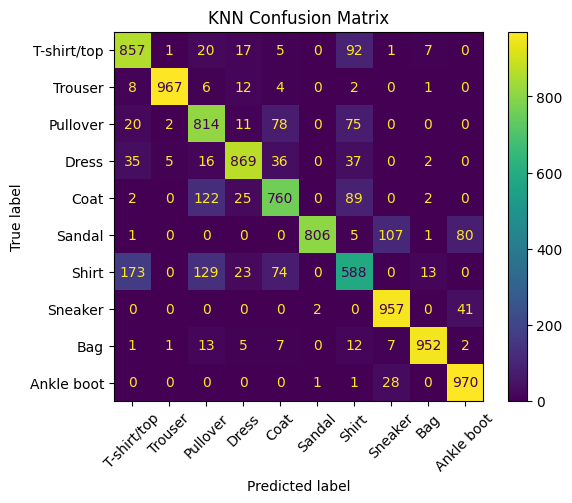

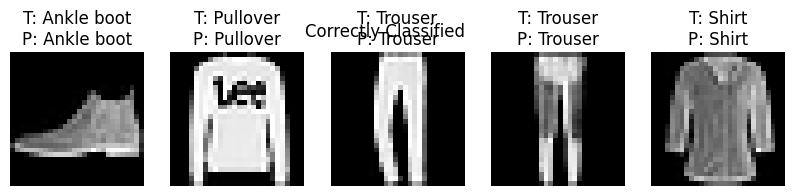

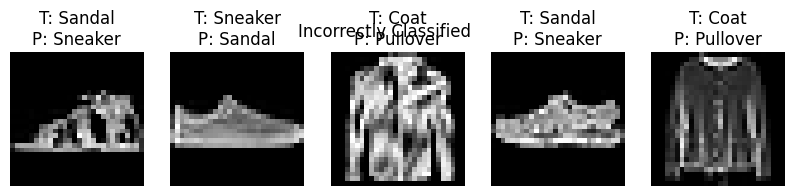

In [ ]:
#Confusion Matrix for KNN Model:
cm = confusion_matrix(y_test, predicted_KNN)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
disp.plot(xticks_rotation=45)
plt.title("KNN Confusion Matrix")
plt.show()

#Showing actual/ predicted outcomes for image classification using KNN model & Comparing the two setups to identify those images that are correctly classified by one setup and incorrectly classified by another:
def plot_comparison(images, true_labels, pred_labels, correct=True, num=5):
    matched = (true_labels == pred_labels) if correct else (true_labels != pred_labels)
    idxs = np.where(matched)[0][:num]

    plt.figure(figsize=(10, 2))
    for i, idx in enumerate(idxs):
        plt.subplot(1, num, i+1)
        plt.imshow(images[idx], cmap='gray')
        plt.axis('off')
        plt.title(f"T: {class_names[true_labels[idx]]}\nP: {class_names[pred_labels[idx]]}")
    plt.suptitle("Correctly Classified" if correct else "Incorrectly Classified")
    plt.show()

#Plotting the correctly classified example images for KNN model:
plot_comparison(x_test, y_test, predicted_KNN, correct=True)

#Plotting the incorrectly classified example images for KNN model:
plot_comparison(x_test, y_test, predicted_KNN, correct=False)


#Setup #2 Begins:  Multilayer Perceptron (MLP) with one hidden layer

In [ ]:
#Setting the seed for reproducibility (the randomly generated numbers will be the same every time the code is run so we can test the code with the same values):
np.random.seed(42)

#Defining the MLP model:
mlp = MLPClassifier(max_iter=100)  #we limit the no. of iterations here to avoid the convergence warnings

#Starting the timer to record the training time for the MLP model:
start_time_MLP = time.time()

#Setting the Hyperparameter Grid (i.e defining the set of values that will be evaluated for each of the following hyperparameters):
param_grid = {
    'hidden_layer_sizes': [(32,), (128,), (224,), (320,)],
    'activation': ['relu', 'tanh'],
    'learning_rate_init': [0.005, 0.05]
}

#Defining the Cross-Validation Method (we are using the StratifiedKFold Cross Validation strategy as it splits the examples' labels evenly across the folds):
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

#Setting up GridSearchCV for Tuning of Hyperparameters:
grid_search = GridSearchCV(mlp, param_grid, cv=cv, n_jobs=-1, verbose=2)

#Training (fitting) the MLP model using the training data set:
grid_search.fit(x_train_flat, y_train)

#Printing the Best Hyperparameters found:
best_params = grid_search.best_params_
print("Best hyperparameters for MLP model:")
print(f"Hidden layer sizes: {best_params['hidden_layer_sizes']}")
print(f"Activation function: {best_params['activation']}")
print(f"Learning rate: {best_params['learning_rate_init']}")

#Defining the Best MLP model (as identified by GridSearchCV method):
best_mlp_model = grid_search.best_estimator_

#Stopping the timer to measure the total time it took to train the MLP model:
end_time_MLP = time.time()
total_time_MLP = end_time_MLP - start_time_MLP
print('Time: %.2f seconds' % total_time_MLP)

#Model makes predictions on the test data set (to see how well it generalizes to unseen data):
predicted_mlp = best_mlp_model.predict(x_test_flat)

#Classification report that displays precision, recall, f1-score, and support for each class:
report_mlp = classification_report(y_test, predicted_mlp, target_names=class_names)
print(report_mlp)

#Confusion Matrix:
cm = confusion_matrix(y_test, predicted_mlp)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
disp.plot(xticks_rotation=45)
plt.title("Confusion Matrix for MLP Model")
plt.show()


Fitting 5 folds for each of 16 candidates, totalling 80 fits


In [ ]:
#Showing actual vs. predicted outcomes for some example images using MLP model:
def plot_mlp_model_predictions(x_test, y_test, predicted_mlp, class_names, only_correct=True, max_images=5):

    #Finding indexes where prediction by the MLP model matches (or does not match) the true/ actual label (target):
    if only_correct:
        condition = (y_test == predicted_mlp)
    else:
        condition = (y_test != predicted_mlp)

    selected_indexes = np.where(condition)[0][:max_images]

    #Plotting the images for the selected indexes:
    plt.figure(figsize=(15, 3))
    for i, idx in enumerate(selected_indexes):
        plt.subplot(1, max_images, i + 1)
        plt.imshow(x_test[idx], cmap='gray')
        plt.axis('off')
        plt.title(f"True: {class_names[y_test[idx]]}\nPred: {class_names[predicted_mlp[idx]]}")
    plt.show()

#Plotting some image examples correctly classified by the MLP model:
plot_mlp_model_predictions(x_test, y_test, predicted_mlp, class_names, only_correct=True)

#Plotting some image examples incorrectly classified by the MLP model:
plot_mlp_model_predictions(x_test, y_test, predicted_mlp, class_names, only_correct=False)
#------------------------------------------------------------------------------------------------------------------

#Comparing one setup (KNN) against another (MLP) to see the difference in their classification of some images:
def plot_model_comparison(x_test, y_test, predicted_knn, predicted_mlp, class_names, model1_correct=True, max_images=10):

    if model1_correct:
        #Finding where KNN model makes a correct classification and MLP model makes an incorrect classification:
        condition = (y_test == predicted_knn) & (y_test != predicted_mlp)
    else:
        #Finding where MLP model makes a correct classification and KNN model makes an incorrect classification:
        condition = (y_test == predicted_mlp) & (y_test != predicted_knn)

    selected_indexes = np.where(condition)[0][:max_images]

    #Plotting the selected images:
    plt.figure(figsize=(15, 3))
    for i, idx in enumerate(selected_indexes):
        plt.subplot(1, max_images, i + 1)
        plt.imshow(x_test[idx], cmap='gray')
        plt.axis('off')
        plt.title(f"True: {class_names[y_test[idx]]}\nKNN: {class_names[predicted_knn[idx]]}\nMLP: {class_names[predicted_mlp[idx]]}")
    plt.show()

#Plotting some example images correctly classified by the KNN model but incorrectly classified by the MLP model:
plot_model_comparison(x_test, y_test, predicted_KNN, predicted_mlp, class_names, model1_correct=True)

#Plotting some example images correctly classified by the MLP model but incorrectly classified by the KNN model:
plot_model_comparison(x_test, y_test, predicted_KNN, predicted_mlp, class_names, model1_correct=False)



NameError: name 'x_test' is not defined